# Exploratory Data Analysis

This notebook provides an exploratory data analysis (EDA) on the dataset.  This will include a data quality analysis, a class distribution analysis, and an analysis of the word counts.  The data quality analysis will include checking for missing values, duplicates, and inconsistencies.  The word counts analysis will provide a summary of the word frequencies for each text.

## Initial Data Review

Here we will import the data and perform some initial data review.  The goal is to look at a sample of the dataset, do initial data quality checks, and identify the number of classes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import sys
sys.path.append('../')

from src.eda.text_stats import add_length_column, describe_lengths
from src.eda.plots import plot_boxplot, plot_cluster_label_distribution, plot_embeddings_with_labels, plot_embeddings_3d_with_labels, plot_3d_umap_by_label_layers
from src.eda.richness import compute_lexical_metrics, group_stats
from src.features.reduction import dimension_reduction
from src.features.embeddings import vectorize_text_array
from src.utils.helpers import md_print

import matplotlib
%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ssgrummo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the training dataset and load it into a pandas DataFrame.  
# Look at the first 5 rows of the dataset to get a sense of what the dataset looks like.  

df = pd.read_csv('../data/raw/initial_data.csv')
df.head(5)

,is_bs,text
0,1,<MASK_36777> just couldn t wish all <MASK_2208...
1,1,<MASK_5645> Chairman <MASK_51378> is going to ...
2,1,"On Friday, it was revealed that former <<MASK_..."
3,1,"On Christmas day, <MASK_18182> announced that ..."
4,1,<MASK_65357> used his annual <MASK_25972> mess...


In [3]:
# Check for missing values in the dataset. If there are any, we need to handle them appropriately.

md_print("### Number of rows:")
md_print(f"{len(df)}")
md_print("### Number of null columns:")
display(df.isnull().sum())


### Number of rows:

44727

### Number of null columns:

is_bs    0
text     0
dtype: int64

In [4]:
# Full duplication
dupes = df.duplicated(subset=["text"])
md_print(f"### Exact duplicate texts: ")
md_print(f"{dupes.sum()}")

### Exact duplicate texts: 

6250

## Class Distribution Analysis

First we need to see if our data is balanced or not. We can do this by checking the distribution of classes.  Unbalanced classes can lead to biased models. 

Let's validate that our training data is balanced by checking the class distribution using a bar chart.

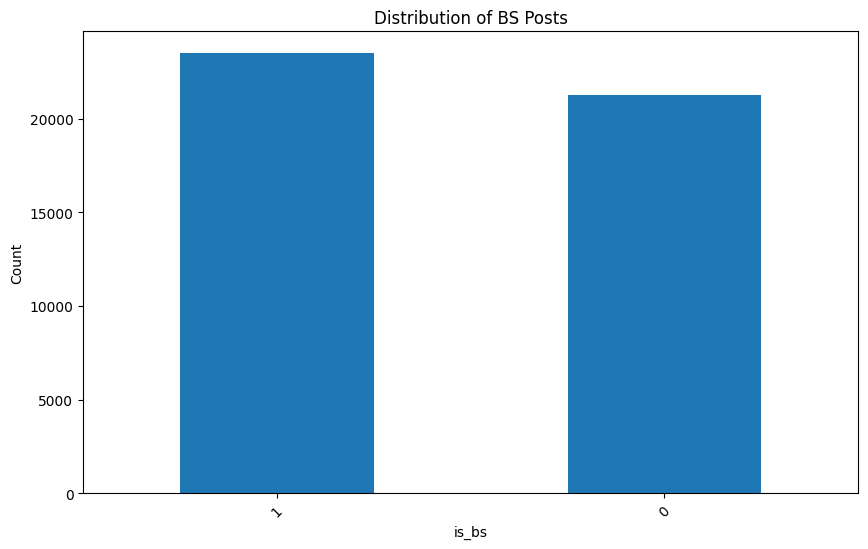

In [5]:
# Distribution of bs
plt.figure(figsize=(10, 6))
df['is_bs'].value_counts().plot(kind='bar')
plt.title('Distribution of BS Posts')
plt.xlabel('is_bs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Vectorized Data Analysis

Here we will analyze the vectorized text data.  The idea is to embed the text into a numerical vector space and then use clustering algorithms to group similar texts together.  We can then use these clusters to identify patterns in the text data and see if they correspond to the labels. 

In [6]:
model_name = "all-MiniLM-L6-v2"

embeddings = vectorize_text_array(df['text'], model_name)
md_print("### Embedding shape")
md_print(f"Each embedding with {model_name} has {embeddings.shape[1]} dimensions")

### Embedding shape

Each embedding with all-MiniLM-L6-v2 has 384 dimensions

/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 2 Dimensional UMAP using MatPlotLib

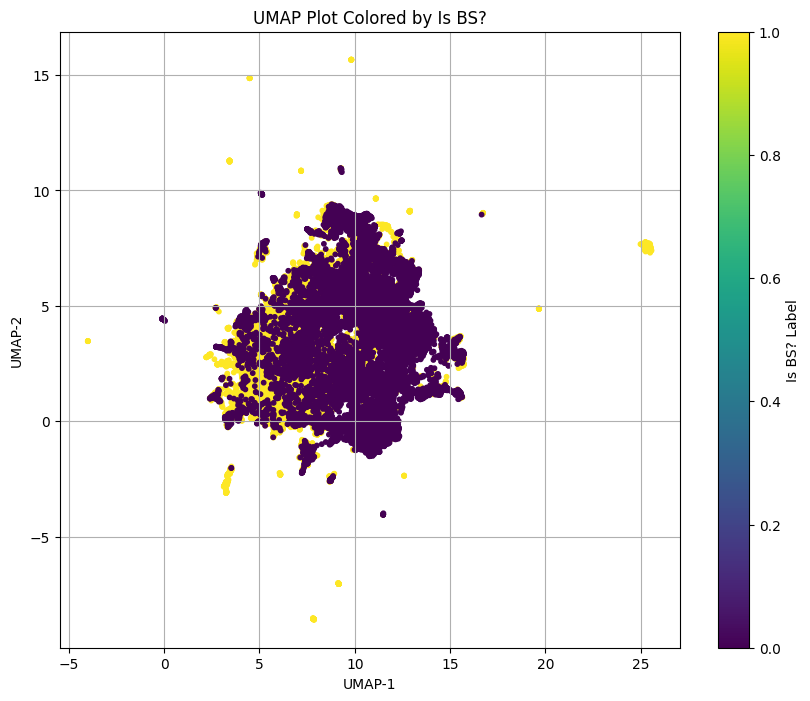

### 3 Dimensional UMAP using MatPlotLib

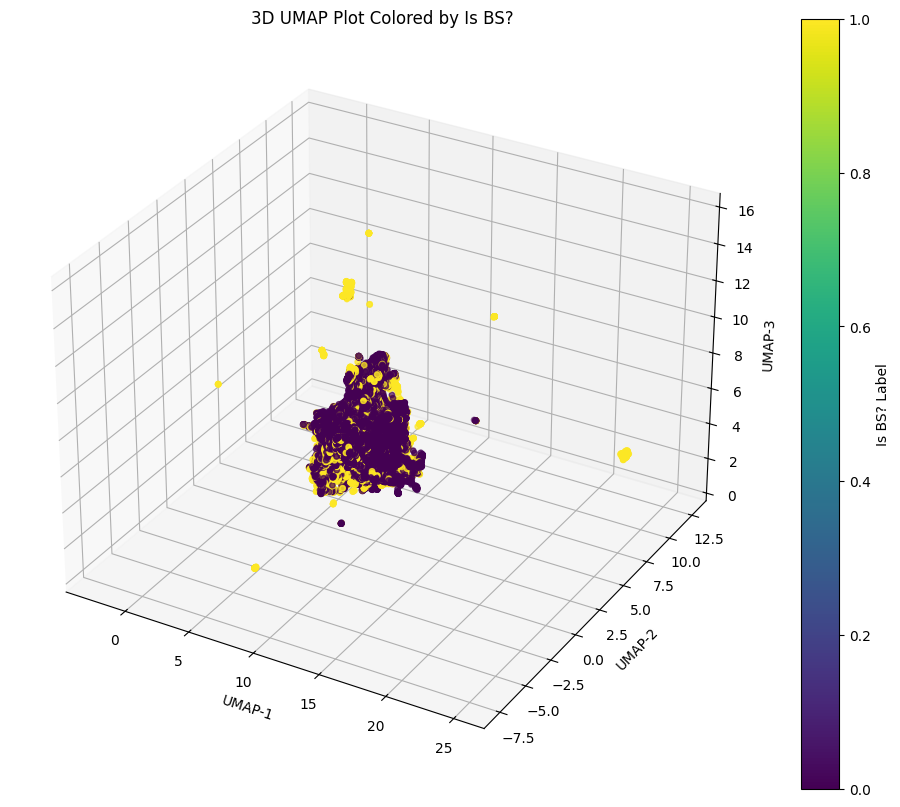

### 3 Dimensionsal UMAP using `plotly`

Interactive Diagram supports zoom and rotation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


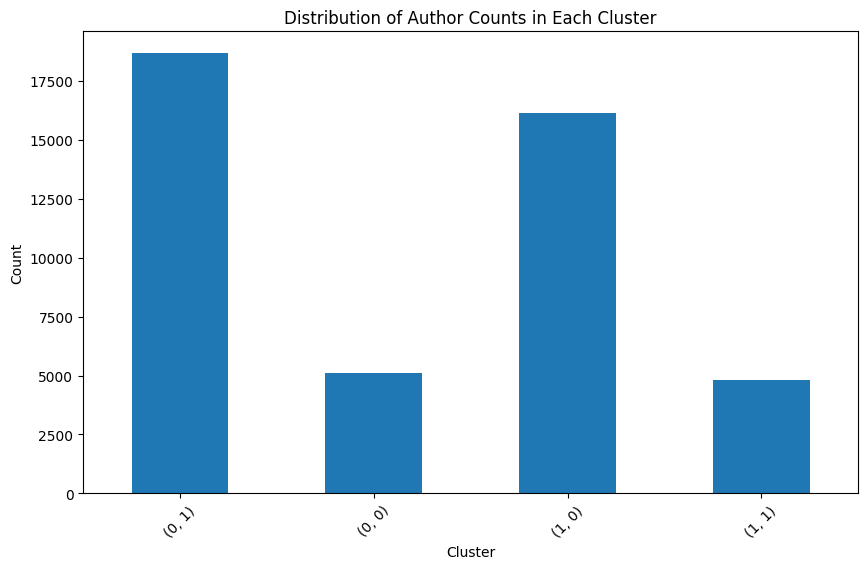

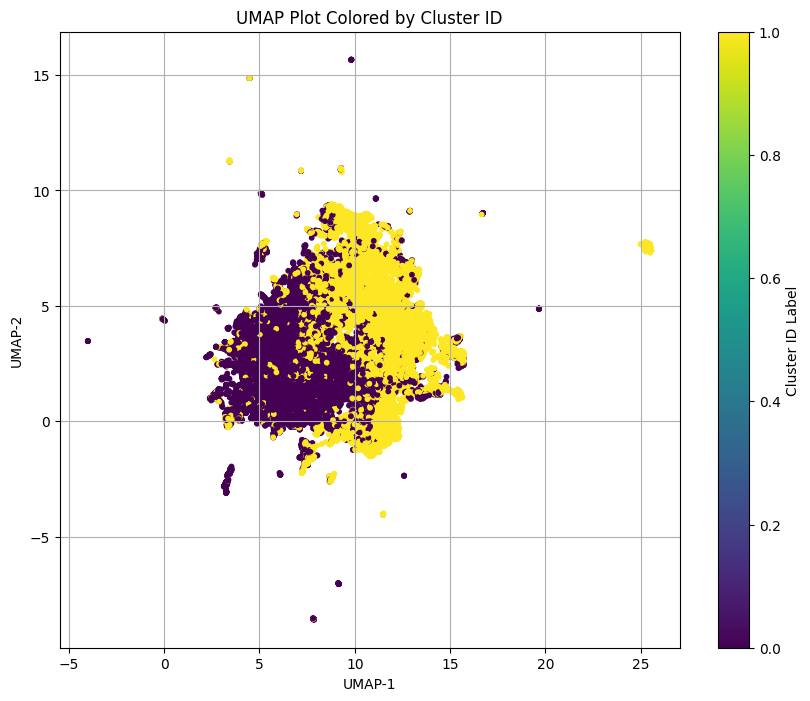

### After PCA Dimensional Reduction

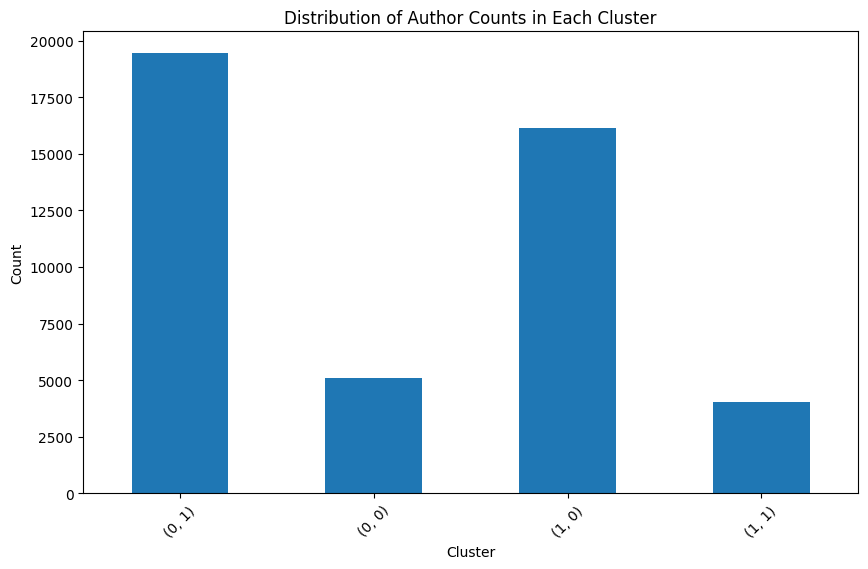

In [7]:
# Now let's create a 2 dimensional representation of our embeddings using UMAP.  This will allow us to plot the embeddings in a 2D space and visualize them.
embeddings_2d = dimension_reduction(embeddings)
embeddings_3d = dimension_reduction(embeddings, n_components=3)

# Let's see if there is any natural clustering with our labels.  This will give us a sense of whether there is any correlation between our labels and our embeddings.
md_print("### 2 Dimensional UMAP using MatPlotLib")
plot_embeddings_with_labels(embeddings_2d, df['is_bs'], "Is BS?")
md_print("### 3 Dimensional UMAP using MatPlotLib")
plot_embeddings_3d_with_labels(embeddings_3d, df['is_bs'], "Is BS?")
md_print("### 3 Dimensionsal UMAP using `plotly`")
md_print("Interactive Diagram supports zoom and rotation")
plot_3d_umap_by_label_layers(embeddings_3d, df['is_bs'], label_name='is_bs')

# Let's use a KMeans clustering model to cluster our text data.  
# We will only use 4 clusters, to correspond to our 4 different authors.
# Given that we already have a set number of categories, running an Elbow test is unnecessary

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embeddings)

# Now let's see how well our clustering corresponds to our labels.
plot_cluster_label_distribution(df, kmeans)

# Let's now visualize this in 2D space.  
plot_embeddings_with_labels(embeddings_2d, kmeans.labels_, "Cluster ID")
plot_3d_umap_by_label_layers(embeddings_3d, pd.Series(kmeans.labels_), label_name='Cluster ID')


# What happens if we reduce the dimensionality of the embeddings?
pca = PCA(n_components=150)
X_phi = pca.fit_transform(embeddings)

kmeans.fit(X_phi)

md_print("### After PCA Dimensional Reduction")
plot_cluster_label_distribution(df, kmeans)

## Text Length Analysis

Used to analyze the text length of each document in the dataset. This can be useful for understanding the distribution of text lengths across different documents and different groups.

### Descriptive stats for chars:

,count,mean,std,min,25%,50%,75%,max
is_bs,,,,,,,,
0,21246.0,2816.978114,2050.029636,123.0,1052.0,2551.0,3879.75,32534.0
1,23481.0,2780.054555,2741.523932,1.0,1540.0,2346.0,3319.00,59613.0


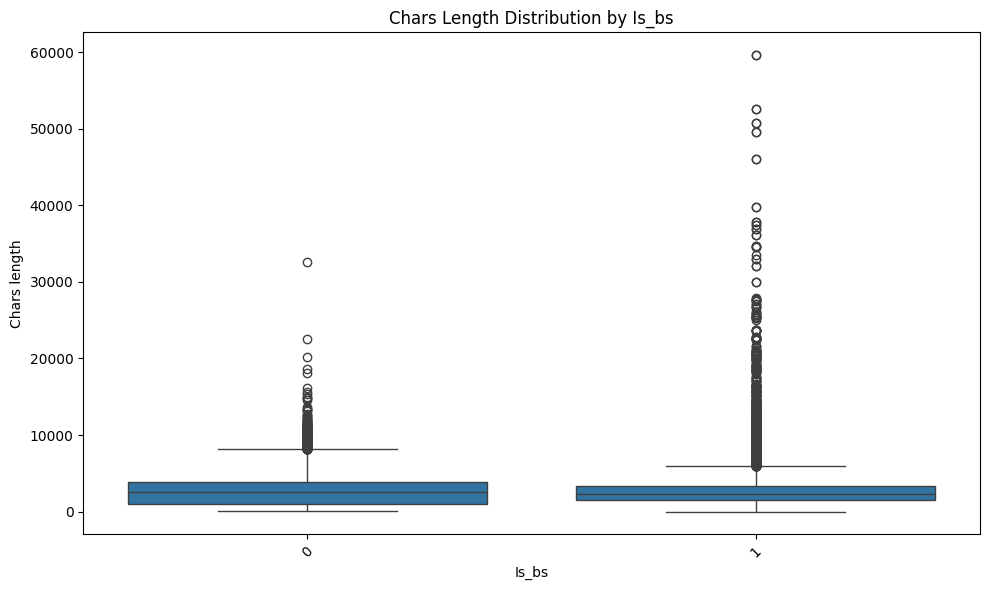

### Descriptive stats for words:

,count,mean,std,min,25%,50%,75%,max
is_bs,,,,,,,,
0,21246.0,371.271628,267.824477,16.0,139.25,344.0,509.0,5160.0
1,23481.0,412.185852,404.534856,0.0,229.00,352.0,493.0,8081.0


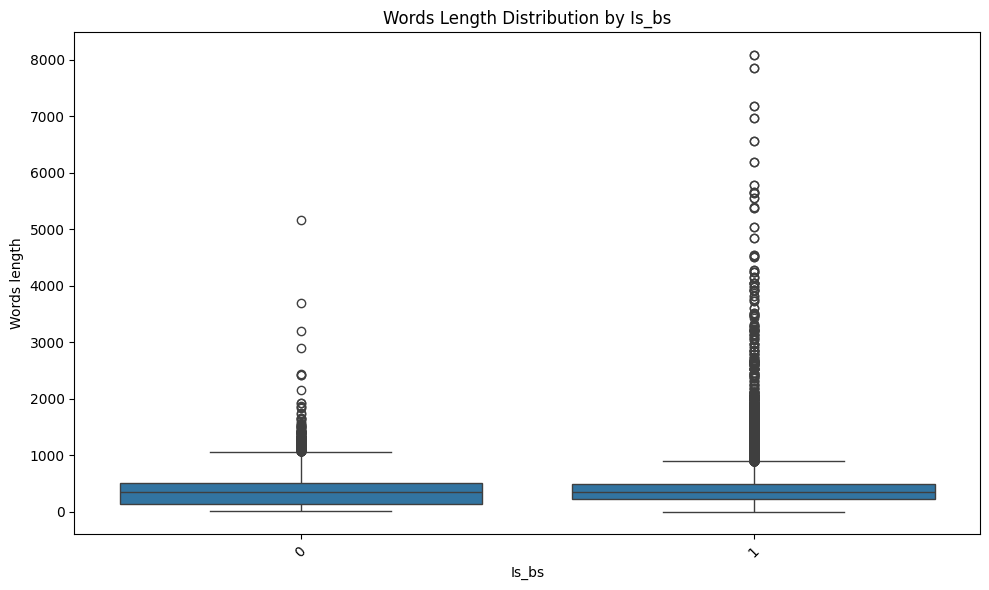

### Descriptive stats for tokens:

,count,mean,std,min,25%,50%,75%,max
is_bs,,,,,,,,
0,21246.0,605.204368,455.229671,24.0,225.0,526.0,835.0,6931.0
1,23481.0,565.994719,538.438103,0.0,312.0,479.0,681.0,11571.0


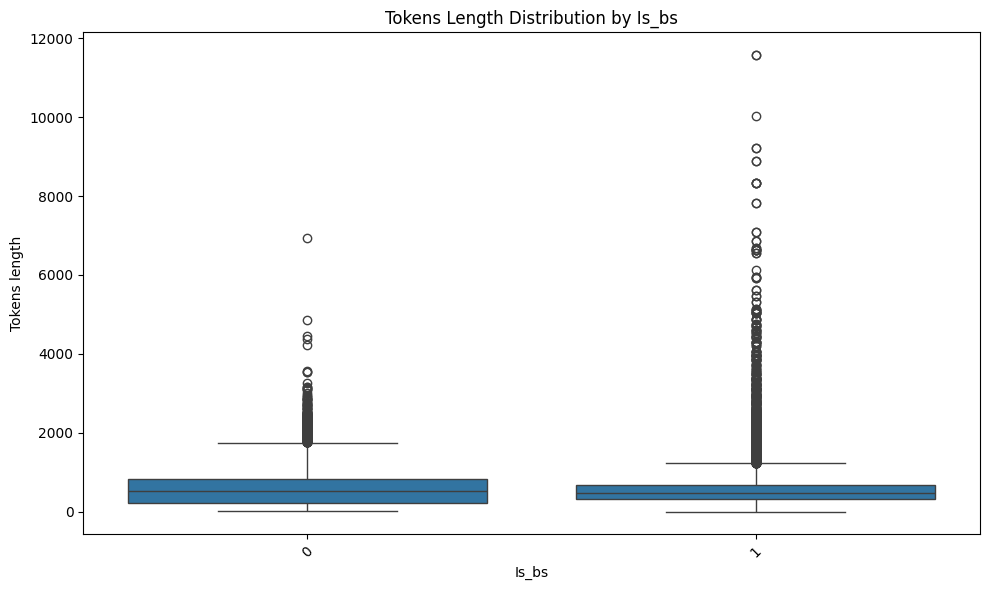

In [8]:
# Assume your dataframe is called `df` and has columns 'text' and 'is_bs'
methods = ['chars', 'words', 'tokens']

for method in methods:
    df_aug, length_col = add_length_column(df, text_col='text', method=method)
    md_print(f"### Descriptive stats for {method}:")
    display(describe_lengths(df_aug, length_col))

    plot_boxplot(df_aug, length_col, group_col='is_bs', title_prefix=f"{method.capitalize()} Length")


## Lexical Richness Check

The idea is that more lexically rich texts will be more distinctive.  Compare these two texts from J.R.R. Tolkien; the first is very lexically rich and feels like what we would expect from Tolkien.  The second is less rich and could have been written by anyone else:

> The Black Rider flung back his hood, and behold! he had a kingly crown; and yet upon no head visible was it set. The red fires shone between it and the mantled shoulders vast and dark. From a mouth unseen there came a deadly laughter.
'Old fool!' he said. 'Old fool! This is my hour. Do you not know Death when you see it? Die now and curse in vain!' And with that he lifted high his sword and flames ran down the blade.  **Return of the King**, _The Siege of Gondor_

> "Noon?" said Sam, trying to calculate.  "Noon of what day?"  **Return of the King**, _The Field of Cormallen_

The hope is that these texts are lexically rich.  We also hope that they are similarly lexically rich across the classes so the model can train on a rich and quintessential feature set.

Relevant Measurements:

1. TTR (Type-Token Ratio): number of unique words / total words
2. MTLD (Measure of Textual Lexical Diversity): stable under text length variation
3. HDD (Harmonic Mean of Lexical Diversity): harmonic mean of TTR and MTLD

For interpreting the results:
- Higher MTLD/HDD → more diverse vocabulary → potential indicator of writing style.
- Lower TTR with longer texts is expected (TTR decreases as text grows).
- Consistent outliers → consider normalization or feature clipping in preprocessing.

In [ ]:
df_lex = compute_lexical_metrics(df)
# Descriptive stats per label
lex_stats = group_stats(df_lex)
measurements = ['mtld', 'ttr', 'hdd']
for m in measurements:
    md_print(f"### Statistics for _{m}_ per label:")
    display(lex_stats[m])

### Statistics for _mtld_ per author:

,count,mean,std,min,25%,50%,75%,max
is_bs,,,,,,,,
0,21246.0,48.248127,23.832612,5.399686,29.712350,42.759613,62.777096,172.856908
1,22851.0,62.791598,24.491616,1.000000,46.126663,62.285603,78.436763,362.880000


### Statistics for _ttr_ per author:

,count,mean,std,min,25%,50%,75%,max
is_bs,,,,,,,,
0,21246.0,0.486805,0.106020,0.119715,0.407407,0.471372,0.54662,0.956522
1,22851.0,0.522871,0.120254,0.126135,0.455319,0.504823,0.55873,1.000000


### Statistics for _hdd_ per author:

,count,mean,std,min,25%,50%,75%,max
is_bs,,,,,,,,
0,21246.0,0.736520,0.075472,0.286001,0.689325,0.747812,0.794480,0.966403
1,22851.0,0.801305,0.060034,0.305336,0.776403,0.809203,0.834411,1.000000


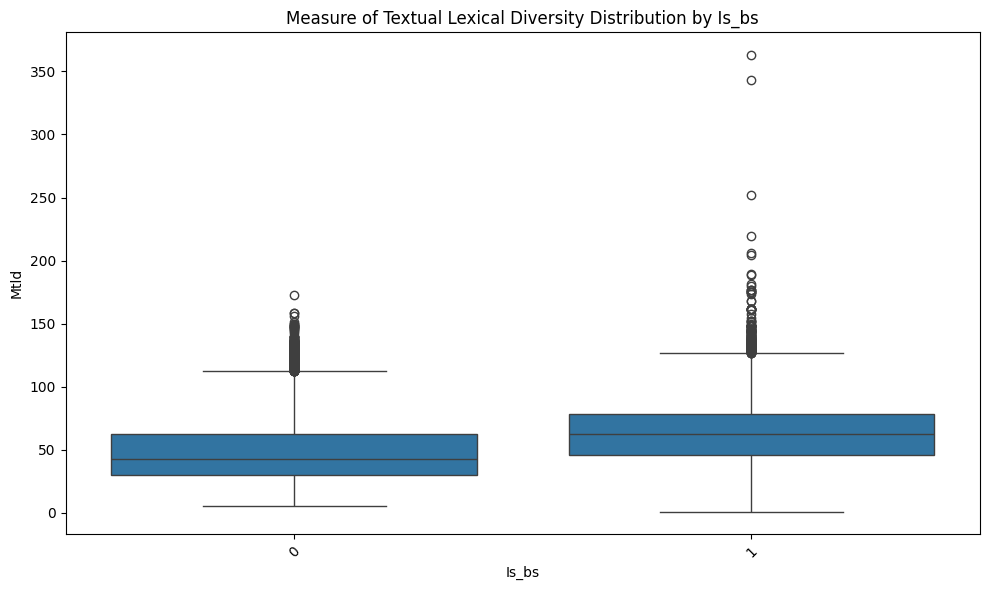

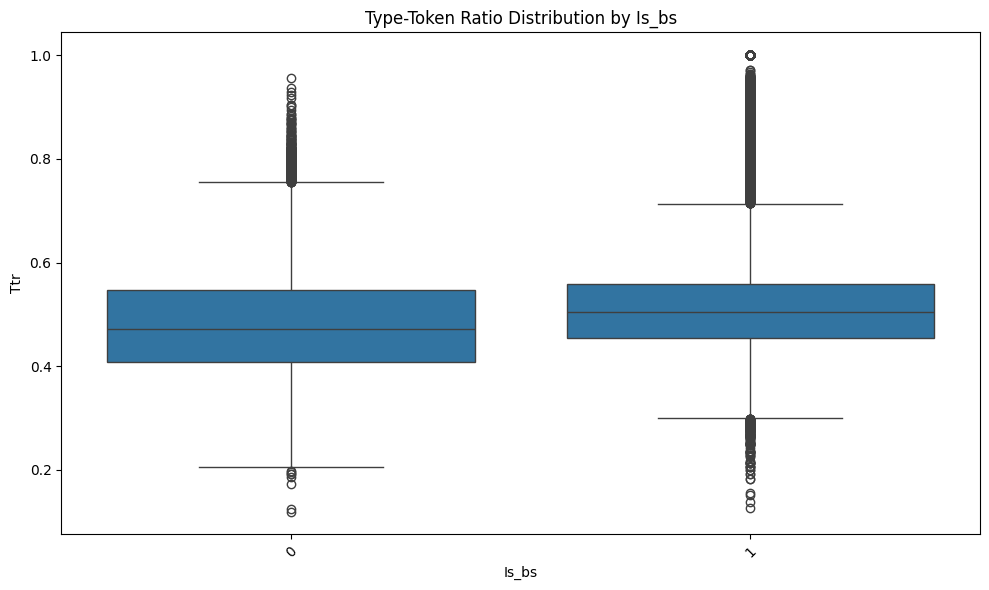

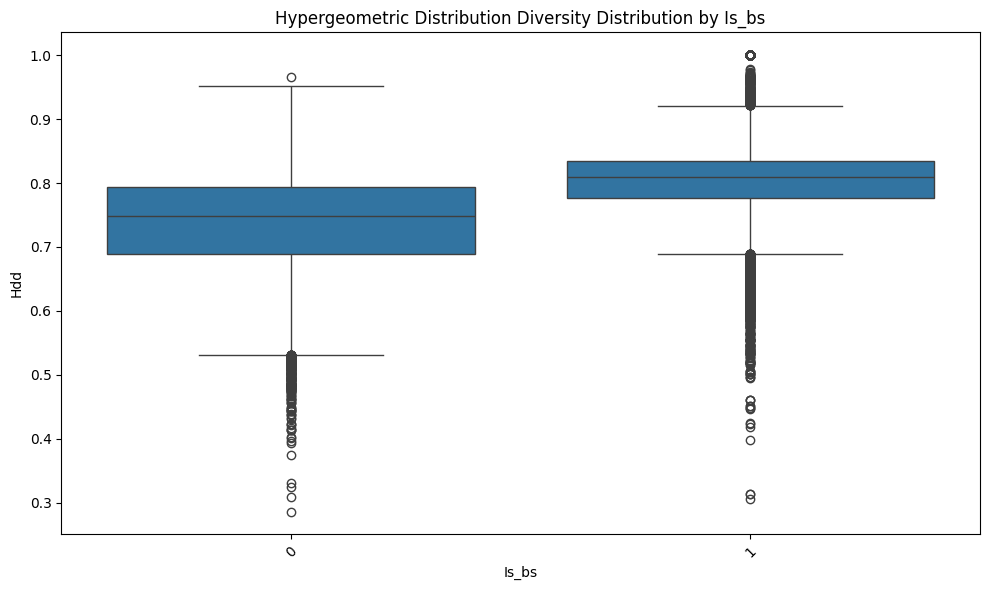

In [12]:
plot_boxplot(df_lex, 'mtld', group_col='is_bs', title_prefix="Measure of Textual Lexical Diversity")
plot_boxplot(df_lex, 'ttr', group_col='is_bs', title_prefix="Type-Token Ratio")
plot_boxplot(df_lex, 'hdd', group_col='is_bs', title_prefix="Hypergeometric Distribution Diversity")


## Topic Leakage Review

The goal is to ensure the model generalizes on semantic patterns, not on the topics discussed.  We will use the `BERTopic` model to identify potential leakage of topics.

In [13]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Optional: Customize vectorizer to limit noise
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

# Instantiate and fit BERTopic
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df["text"].tolist())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [152]:
df["topic"] = topics
topic_counts = df.groupby(["topic", "is_bs"]).size().unstack(fill_value=0)
topic_counts["total"] = topic_counts.sum(axis=1)
topic_counts["fake_ratio"] = topic_counts[1] / topic_counts["total"]
topic_counts.sort_values("fake_ratio", ascending=False).head(10)


is_bs,0,1,total,fake_ratio
topic,,,,
253,0,24,24,1.0
415,0,12,12,1.0
374,0,14,14,1.0
202,0,29,29,1.0
377,0,14,14,1.0
379,0,14,14,1.0
380,0,14,14,1.0
381,0,14,14,1.0
98,0,59,59,1.0


In [153]:
topic_counts.columns.name = None
topic_counts.reset_index(inplace=True)
topic_counts

,topic,0,1,total,fake_ratio
0,-1,8187,10723,18910,0.567054
1,0,686,151,837,0.180406
2,1,445,261,706,0.369688
3,2,0,633,633,1.000000
4,3,388,60,448,0.133929
...,...,...,...,...,...
470,469,0,10,10,1.000000
471,470,0,10,10,1.000000
472,471,4,6,10,0.600000
473,472,9,1,10,0.100000


In [28]:
md_print(f"Total Number of Topics: {str(topic_counts.shape[0])}")
md_print(f"Number of Topics only in Fake News: {str(topic_counts[topic_counts['fake_ratio'] == 1 ].shape[0])}")
md_print(f"Number of Topics with fake_ratio above 50%: {str(topic_counts[topic_counts['fake_ratio'] > 0.5 ].shape[0])}")
md_print(f"Number of Topics with fake_ratio below 50%: {str(topic_counts[topic_counts['fake_ratio'] < 0.5 ].shape[0])}")
md_print(f"Number of Topics only in Real News: {str(topic_counts[topic_counts['fake_ratio'] == 0 ].shape[0])}")
md_print(f"Number of Topics with fake_ratio between 40-60%%: {str(topic_counts[(topic_counts['fake_ratio'] > 0.4) & (topic_counts['fake_ratio'] < 0.6)].shape[0])}")

Total Number of Topics: 475

Number of Topics only in Fake News: 88

Number of Topics with fake_ratio above 50%: 253

Number of Topics with fake_ratio below 50%: 217

Number of Topics only in Real News: 53

Number of Topics with fake_ratio between 40-60%%: 25

In [46]:
# Get the set of topics with fake_ratio between 40% and 60%
balanced_topics = topic_counts.query("fake_ratio >= 0.4 and fake_ratio <= 0.6")

balanced_topics.reset_index(inplace=True)
# Filter the main dataframe to only include those topics
df_balanced = df[(df["topic"].isin(balanced_topics['topic'])) & (df['topic'] != -1)]

# Count number of rows
num_rows = len(df_balanced)
print(f"Number of rows with balanced topics (40%-60% fake): {num_rows}")


Number of rows with balanced topics (40%-60% fake): 1084


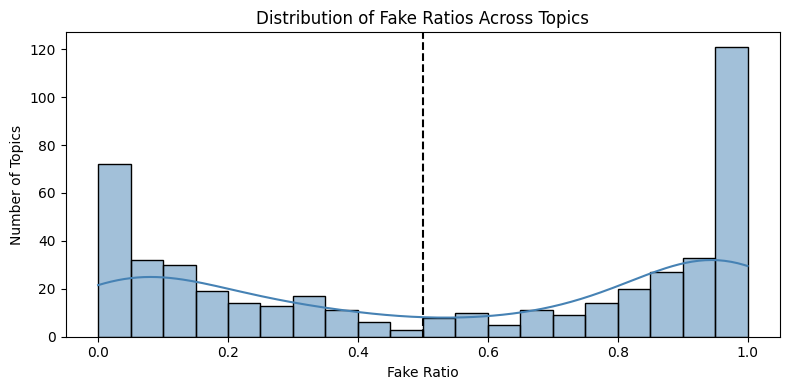

In [63]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(topic_counts['fake_ratio'], bins=20, kde=True, color='steelblue')
plt.axvline(0.5, color='black', linestyle='--')
plt.title("Distribution of Fake Ratios Across Topics")
plt.xlabel("Fake Ratio")
plt.ylabel("Number of Topics")
plt.tight_layout()
plt.show()


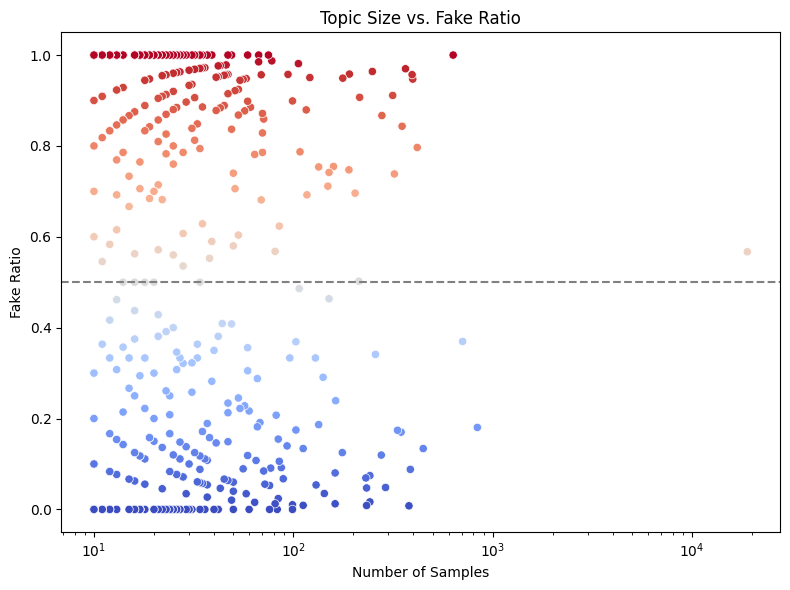

In [67]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=topic_counts, x='total', y='fake_ratio', hue='fake_ratio', palette='coolwarm', legend=False)
plt.axhline(0.5, linestyle='--', color='gray')
plt.title("Topic Size vs. Fake Ratio")
plt.xlabel("Number of Samples")
plt.ylabel("Fake Ratio")
plt.xscale('log')
plt.tight_layout()
plt.show()


In [60]:
valid_mask = df['topic'] != -1
# Filter embeddings and labels using that mask
filtered_embeddings = embeddings_3d[valid_mask.values]
filtered_labels = df.loc[valid_mask, 'topic']
plot_3d_umap_by_label_layers(embeddings=filtered_embeddings,
                             labels=filtered_labels, 
                             label_name='Topic ID')


## Topic Majority Confusion Matrix

High Correlation implies Topic Leakages.

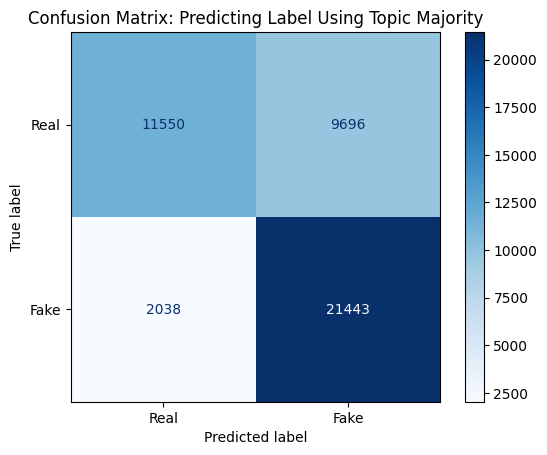

In [61]:
md_print("## Topic Majority Confusion Matrix")
md_print("High Correlation implies Topic Leakages.")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assign each topic a majority class label
topic_majority_label = df.groupby('topic')['is_bs'].agg(lambda x: int(x.mean() > 0.5))
df['topic_pred'] = df['topic'].map(topic_majority_label)

cm = confusion_matrix(df['is_bs'], df['topic_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Predicting Label Using Topic Majority")
plt.show()
